In [1]:
#thougth process
#get the restaurant reviews
#classify negative < 3 positive >=3. and put as a target column
#clean the data
#split into train test dataset
#Tokenize
#Remove Stopwords
#Vectorizing the text using TF_IDF etc
#build models 1st manual model by
#Generate a list of positive words and a list of negative words from
#the dictionary downloaded from opinion_lexicon:


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings("ignore")
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC
import joblib
from pathlib import Path
import sklearn
import logging
logger = logging.getLogger()
logger.disabled = True

In [2]:
from azureml.core import Workspace, Dataset, Datastore
subscription_id = 'Redacted'
resource_group = 'calcutta_demos'
workspace_name = 'Houston-techsummit-workspace'

workspace = Workspace(subscription_id, resource_group, workspace_name)

In [3]:
#Get the yelp Dataset from adlsgen2
dataset_yelp_review = Dataset.get_by_name(workspace, 'yelp_review')
dataset_yelp_review.take(3).to_pandas_dataframe()

Credentials are not provided to access data from the source. Please sign in using identity with required permission granted.
Interactive sign-in timeout: 120 sec.
To change the sign-in tenant, restart the session with tenant ID set to environment variable "AZUREML_DATA_ACCESS_TENANT_ID" before sign in.
To always use device code for interactive sign-in, set environment variable "AZUREML_DATA_ACCESS_USE_DEVICE_CODE" to "true".
To configure timeout, set environment variable "AZUREML_DATA_ACCESS_INTERACT_TIMEOUT" to the number of seconds.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code RYXZ7DYTJ to authenticate.


InteractiveBrowserCredential.get_token failed: Failed to open a browser


,review_id,business_id,stars,useful,funny,cool,date,text,user_id
0,xQY8N_XvtGbearJ5X4QryQ,-MhfebM0QIsKt87iDN-FNw,2,5,0,0,2015-04-15,"As someone who has worked with many museums, I...",OwjRMXRC0KyPrIlcjaXeFQ
1,UmFMZ8PyXZTY2QcwzsfQYA,lbrU8StCq3yDfr-QMnGrmQ,1,1,1,0,2013-12-07,I am actually horrified this place is still in...,nIJD_7ZXHq-FX8byPMOkMQ
2,LG2ZaYiOgpr2DK_90pYjNw,HQl28KMwrEKHqhFrrDqVNQ,5,1,0,0,2015-12-05,I love Deagan's. I do. I really do. The atmosp...,V34qejxNsCbcgD8C0HVk-Q


In [4]:
#Conver to Pandas Dataframe
df_yelp_review = dataset_yelp_review.to_pandas_dataframe()

In [5]:
df_yelp_review.count()

review_id      1009534
business_id    1009534
stars          1009534
useful         1009534
funny          1009534
cool           1009534
date           1009534
text           1009534
user_id        1009534
dtype: int64

In [6]:
df_yelp_review = df_yelp_review[:10000]

In [7]:
df_yelp_review.count()

review_id      10000
business_id    10000
stars          10000
useful         10000
funny          10000
cool           10000
date           10000
text           10000
user_id        10000
dtype: int64

In [8]:
# Create new column "Actual_Sentiment" that stored 0's or 1's.
# 0 being Negative, 1 being Positive
import numpy as np
df_yelp_review["Actual_Sentiment"] = np.where(df_yelp_review["stars"] >= 3, 1, 0)
df_yelp_review.head(3)

,review_id,business_id,stars,useful,funny,cool,date,text,user_id,Actual_Sentiment
0,xQY8N_XvtGbearJ5X4QryQ,-MhfebM0QIsKt87iDN-FNw,2,5,0,0,2015-04-15,"As someone who has worked with many museums, I...",OwjRMXRC0KyPrIlcjaXeFQ,0
1,UmFMZ8PyXZTY2QcwzsfQYA,lbrU8StCq3yDfr-QMnGrmQ,1,1,1,0,2013-12-07,I am actually horrified this place is still in...,nIJD_7ZXHq-FX8byPMOkMQ,0
2,LG2ZaYiOgpr2DK_90pYjNw,HQl28KMwrEKHqhFrrDqVNQ,5,1,0,0,2015-12-05,I love Deagan's. I do. I really do. The atmosp...,V34qejxNsCbcgD8C0HVk-Q,1


In [9]:
#We only need the text (review) and Actual_Sentiment columns for sentiment prediction
df_ml_yelp_review = df_yelp_review[['text','Actual_Sentiment']]
df_ml_yelp_review.head(5)

,text,Actual_Sentiment
0,"As someone who has worked with many museums, I...",0
1,I am actually horrified this place is still in...,0
2,I love Deagan's. I do. I really do. The atmosp...,1
3,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",0
4,"Oh happy day, finally have a Canes near my cas...",1


In [10]:
df_ml_yelp_review.shape

(10000, 2)

In [11]:
#Build punctuation dictionary
import unicodedata
import sys

# Create a dictionary of punctuation characters
punctuation = dict.fromkeys(i for i in range(sys.maxunicode)
                            if unicodedata.category(chr(i)).startswith('P'))
# Add the backtick/ Grave accent character
punctuation.update({96:None})

In [14]:
####******
#Let us clean up and make the data ready
import re 
def function_clean(text):
    #convert into lowercase
    text = text.lower()
    #removing the URL Http
    text = re.sub(r"http\S+", "", text) 
    # Removal of mentions
    #text = re.sub("@[^\s]*", "", text)
    # Removal of hashtags
    #text = re.sub("#[^\s]*", "", text)
    # Removal of numbers
    text = re.sub('[0-9]*[+-:]*[0-9]+', '', text)
    text = re.sub("'s", "", text)   
    #remove all punctuation from the text.
    text = str(text.translate(punctuation))
    
    return text

In [12]:
#Let us clean up and make the data ready
import re 
import string
#pip install nltk
import nltk
#nltk.download('stopwords')

from nltk.corpus import stopwords 
ENGLISH_STOP_WORDS = stopwords.words('english')

def function_clean_stop(text):
    #convert into lowercase
    text = text.lower()
    #removing the URL Http
    text = re.sub(r"http\S+", "", text) 
    # Removal of mentions
    #text = re.sub("@[^\s]*", "", text)
    # Removal of hashtags
    #text = re.sub("#[^\s]*", "", text)
    # Removal of numbers
    text = re.sub('[0-9]*[+-:]*[0-9]+', '', text)
    text = re.sub("'s", "", text)   
    #remove all punctuation from the text.
    text = str(text.translate(punctuation))
    
    listofwords = text.strip().split()          # to remove any space from beginning and the end of text
    tokenized_words = []    
    for word in listofwords:
        if not word in ENGLISH_STOP_WORDS:
            lemm_word = WordNetLemmatizer().lemmatize(word)
            if len(lemm_word)>0:
                tokenized_words.append(lemm_word)
    return_str = ' '.join([str(elem) for elem in tokenized_words])             
    return(return_str)
    #return text

In [13]:
print (function_clean_stop("the food is great"))

food great


In [14]:
# applying the cleaning function to text column
df_ml_yelp_review['text'] = df_ml_yelp_review['text'].apply(lambda text: function_clean_stop(text))

In [15]:
df_ml_yelp_review.head(5)

,text,Actual_Sentiment
0,someone worked many museum eager visit gallery...,0
1,actually horrified place still business year o...,0
2,love deagan really atmosphere cozy festive shr...,1
3,dismal lukewarm defrostedtasting texmex glop m...,0
4,oh happy day finally cane near casa yes others...,1


In [16]:
#Splitting the data to train and test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_ml_yelp_review["text"]
y = df_ml_yelp_review["Actual_Sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [17]:
y.value_counts()

1    7750
0    2250
Name: Actual_Sentiment, dtype: int64

In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000,), (2000,), (8000,), (2000,))

In [20]:
####******
#Now it is time to preprocess the reviews because all these modifications will directly affect the classifier’s performance.
# As we are going to use words as features so we can use some text formatting techniques which will help us in feature extraction
#  including removing punctuation marks/digits ,and also stop-words. In addition, the implementation of lemmatization words using NLTK
#   can be workable to maximize the performance. Tokenization is the last step to break reviews up into words and other meaningful tokens.
import string
#pip install nltk
import nltk
#nltk.download('stopwords')

from nltk.corpus import stopwords 
ENGLISH_STOP_WORDS = stopwords.words('english')

def my_tokenizer(sentence):

    listofwords = sentence.strip().split()          # to remove any space from beginning and the end of text
    tokenized_words = []    
    for word in listofwords:
        if not word in ENGLISH_STOP_WORDS:
            lemm_word = WordNetLemmatizer().lemmatize(word)
            if len(lemm_word)>0:
                tokenized_words.append(lemm_word)
    return(tokenized_words)

In [19]:
#lem = nltk.stem.wordnet.WordNetLemmatizer()
#nltk.download('wordnet')

In [76]:
####******
#Vectorizing the text using TF_IDF

#By implementing the sklearn library, we can use TF_IDF vectorizing to find 
#the weighted words that occur more frequently in the document that leads to
# creation of the bag of words model. So our features will be the words or sequence of
# words of these reviews. We are going to explore different models with
# the combinations of n_grams (unigrams,bigrams,trigrams).
#min_df float or int, default=1
#When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.
# This value is also called cut-off in the literature. If float in range of [0.0, 1.0], 
# the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

#ngram_rangetuple (min_n, max_n), default=(1, 1)
#The lower and upper boundary of the range of n-values for different n-grams to be extracted. All values of n such 
#that min_n <= n <= max_n will be used. For example an ngram_range of (1, 1) means only unigrams, (1, 2) means
# unigrams and bigrams, and (2, 2) means only bigrams. Only applies if analyzer is not callable.

#tokenizer callable, default=None
#Override the string tokenization step while preserving the preprocessing and n-grams generation steps. 
#Only applies if analyzer == 'word'.


from sklearn.feature_extraction.text import TfidfVectorizer
vect_1 = TfidfVectorizer(min_df=100,tokenizer=my_tokenizer, stop_words={'english'}, ngram_range=(1,3)).fit(X_train)
X_train1 = vect_1.transform(X_train)
X_test1 = vect_1.transform(X_test)


In [78]:
####******
#counting most repetitive words 
word_counts = np.array(np.sum(X_train1, axis=0)).reshape((-1,))
words = np.array(vect_1.get_feature_names())
words_df = pd.DataFrame({"word":words, "count":word_counts})
words_df.sort_values(by="count",ascending=False).head(20)

,word,count
240,food,356.042354
280,great,340.348957
481,place,339.758881
276,good,327.373251
571,service,282.334077
659,time,255.992016
363,like,216.151649
263,get,215.649508
443,one,210.083729
39,back,204.448698


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect_2 = TfidfVectorizer(min_df=100,stop_words={'english'}, ngram_range=(1,3)).fit(X_train)
X_train1 = vect_2.transform(X_train)
X_test1 = vect_2.transform(X_test)

In [20]:
#counting most repetitive words 
word_counts = np.array(np.sum(X_train1, axis=0)).reshape((-1,))
words = np.array(vect_2.get_feature_names())
words_df = pd.DataFrame({"word":words, "count":word_counts})
words_df.sort_values(by="count",ascending=False).head(20)

,word,count
239,food,357.149016
279,great,341.348861
480,place,340.881153
275,good,328.402323
570,service,283.284314
658,time,256.989217
362,like,217.043932
262,get,216.716368
442,one,211.009900
38,back,205.439287


In [24]:
#pip install sklearn --upgrade
#pip install -U imbalanced-learn
#pip install imblearn
#pip install delayed


In [21]:
#The only challenge that we’ve faced was about balancing the train dataset in terms of having the equal 
#numbers of positive and negative reviews for our two classes. 
#So we are using SMOTE to balanace our target(class) column.
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

#SMOTE the training data
sm = SMOTE(random_state=1)
X_bal, y_bal = sm.fit_resample(X_train1, y_train)


In [22]:
X_bal.shape

(12350, 752)

In [23]:
y_bal.value_counts()

1    6175
0    6175
Name: Actual_Sentiment, dtype: int64

### 0. Creating a Baseline Classification Model



In [24]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='uniform', random_state=1)

# "Train" model
dummy.fit(X_bal, y_bal)

# Get accuracy score
dummy.score(X_test1,y_test)

0.492

In [25]:
import matplotlib.pyplot as plt

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


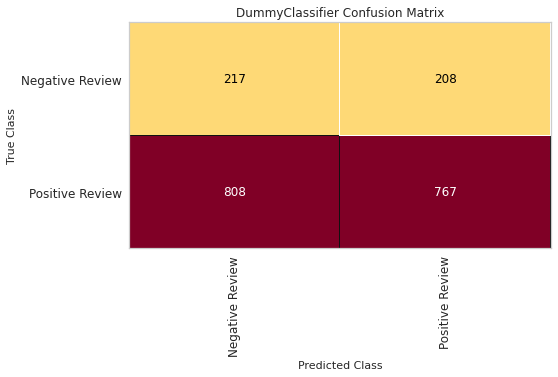

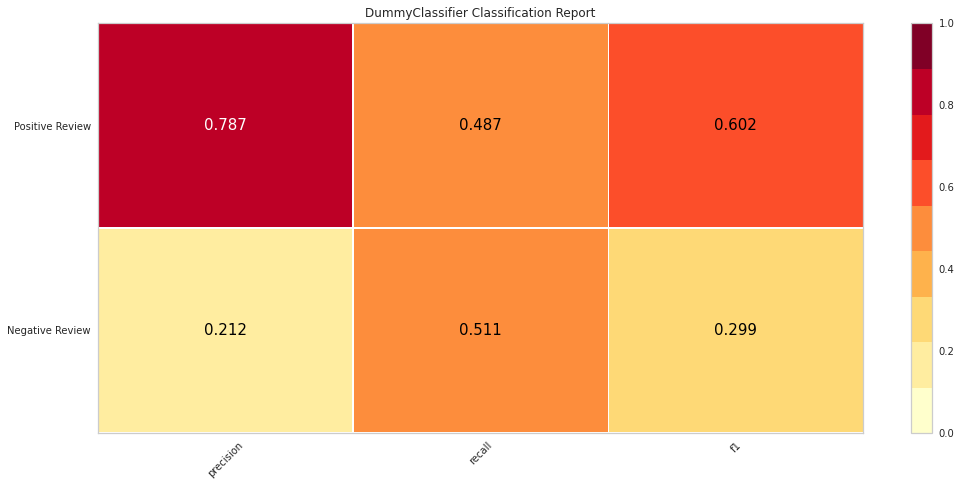

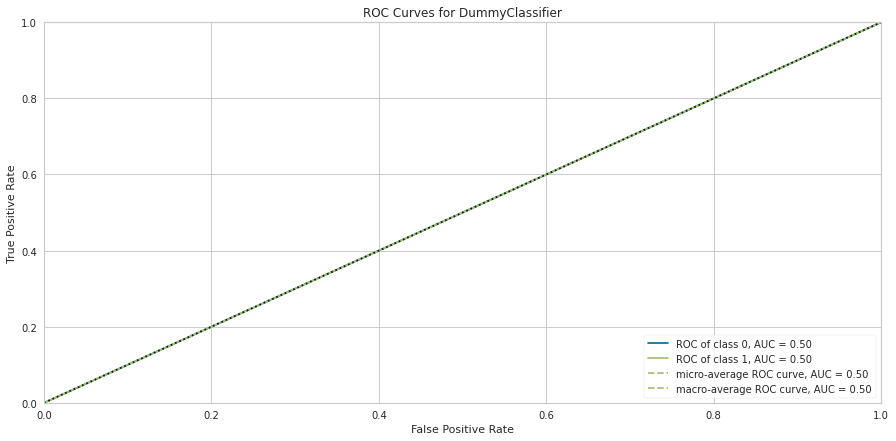

In [26]:

classes = ['Negative Review','Positive Review']
cm = ConfusionMatrix(dummy, classes=classes, percent=False)

#Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
#cm.fit(X_train, y_train)


#To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
#and then creates the confusion_matrix from scikit learn.
cm.score(X_test1,y_test)

# change fontsize of the labels in the figure
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 15
#How did we do?
cm.poof()

# Instantiate the visualizer
visualizer = ClassificationReport(dummy, classes=classes)
#visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test1,y_test)  # Evaluate the model on the test data
g = visualizer.poof()

# ROC and AUC
#Instantiate the visualizer
visualizer = ROCAUC(dummy)

#visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.fit(X_bal, y_bal)
visualizer.score(X_test1,y_test)  # Evaluate the model on the test data
plt.rcParams['font.size'] = 20
g = visualizer.poof()

### By comparing the baseline classifier to our trained classifier, we can see the improvements.



### 1. Logistic Regression model

In [27]:
# fitting a logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

# Fitting Logistic regression to the training set
logreg = LogisticRegression(solver='lbfgs',multi_class='auto',random_state=1)
logreg.fit(X_bal, y_bal)

# Predicting the test set results
y_pred_logreg = logreg.predict(X_test1)

# Training score
print(f"Score on training set: {logreg.score(X_train1,y_train)}")
print(f"Score on test set: {logreg.score(X_test1,y_test)}")

Score on training set: 0.904875
Score on test set: 0.869


#### Model Evaluation
As shown above, our model test accuracy is 0.90. In order to evaluate the model further, we can extract some important evaluation metrics from the classification report such as precision, recall, and f1_score. As shown in the following report, as the f1_score is 0.92 for class 1 and 0.76 for class 0, therefore we can conclude this model is better in predicting positive reviews than negative ones.

In [28]:
from sklearn.metrics import classification_report
print('The Confusion Matrix')
con_mat_lr = confusion_matrix(y_test, y_pred_logreg)
df_cm_lr = pd.DataFrame(con_mat_lr, columns = ['Predicted 0','Predicted 1'], index = ['True 0','True 1'])
display(df_cm_lr)

The Confusion Matrix


,Predicted 0,Predicted 1
True 0,359,66
True 1,196,1379


In [27]:
type(y_test)

pandas.core.series.Series

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


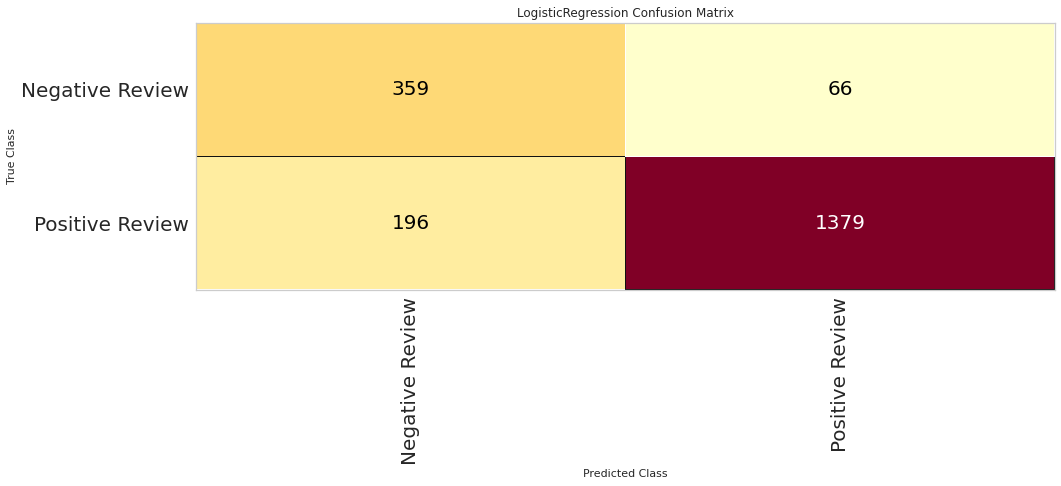

In [29]:
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Instantiate the classification model 
#logreg
#The ConfusionMatrix visualizer taxes a model
classes = ['Negative Review','Positive Review']
cm = ConfusionMatrix(logreg, classes=classes, percent=False)

#Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
#cm.fit(X_train, y_train)


#To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
#and then creates the confusion_matrix from scikit learn.
cm.score(X_test1,y_test)

# change fontsize of the labels in the figure
plt.rcParams['figure.figsize'] = (7, 7)
plt.rcParams['font.size'] = 15
#How did we do?
cm.poof()


In [30]:
print('The Classification report')
report = classification_report(y_test, y_pred_logreg, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

The Classification report


,precision,recall,f1-score,support
0,0.646847,0.844706,0.732653,425.000
1,0.954325,0.875556,0.913245,1575.000
accuracy,0.869000,0.869000,0.869000,0.869
macro avg,0.800586,0.860131,0.822949,2000.000
weighted avg,0.888986,0.869000,0.874869,2000.000


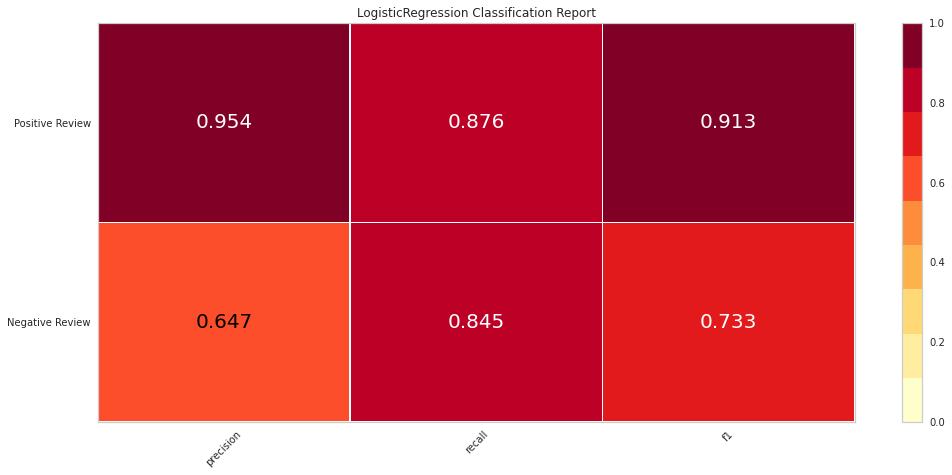

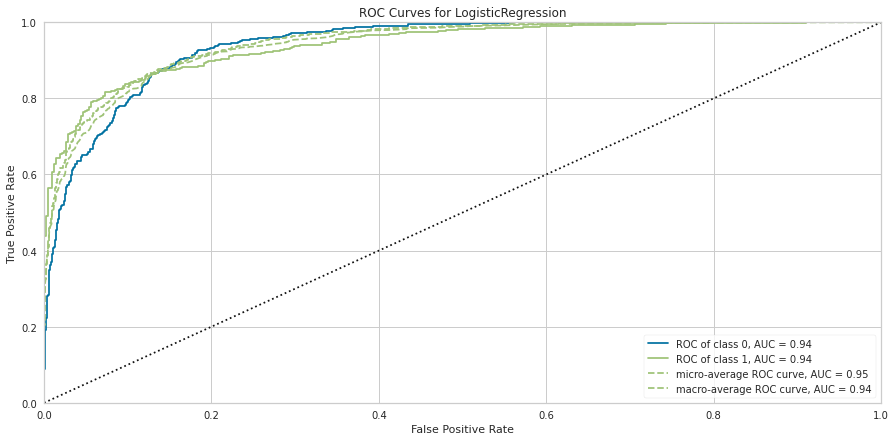

In [31]:
# Precision, Recall, and F1 Score
# set the size of the figure and the font size 
#%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20

# Instantiate the visualizer
visualizer = ClassificationReport(logreg, classes=classes)
#visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test1,y_test)  # Evaluate the model on the test data
g = visualizer.poof()

# ROC and AUC
#Instantiate the visualizer
visualizer = ROCAUC(logreg)

#visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.fit(X_bal, y_bal)
visualizer.score(X_test1,y_test)  # Evaluate the model on the test data
plt.rcParams['font.size'] = 20
g = visualizer.poof()

### Grid search (logistic) -> hyperparameter tuning
Let's now try to optimize some hyperparameters. We will start off with the logistic regression by finding out the optimal value for parameter C by applying the Grid search.

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

estimators = [('classifier',LogisticRegression(solver='lbfgs',multi_class='auto',random_state=1))]
pipe = Pipeline(estimators)

params = {'classifier__C' : [10**j for j in range(-4,4)]}
grid_search = GridSearchCV(pipe, param_grid=params,cv=5)

In [33]:
fitted_search = grid_search.fit(X_bal, y_bal)

In [34]:
fitted_search.best_estimator_

Pipeline(steps=[('classifier', LogisticRegression(C=10, random_state=1))])

After grid search we found our optimal parameter and applied in the our model. As a result, the train and test accuracy slightly are increased.

In [35]:
logreg = LogisticRegression(C=10, random_state=1)
logreg.fit(X_bal, y_bal)

# Predicting the test set results
y_pred_logreg = logreg.predict(X_test1)

# Training score
print(f"Score on training set: {logreg.score(X_train1,y_train)}")
print(f"Score on test set: {logreg.score(X_test1,y_test)}")

# Creating confusion matrix/ dataFrame
con_mat_lr = confusion_matrix(y_test, y_pred_logreg)
df_cm_lr = pd.DataFrame(con_mat_lr, columns = ['Predicted 0','Predicted 1'], index = ['True 0','True 1'])
df_cm_lr

Score on training set: 0.918125
Score on test set: 0.872


,Predicted 0,Predicted 1
True 0,351,74
True 1,182,1393


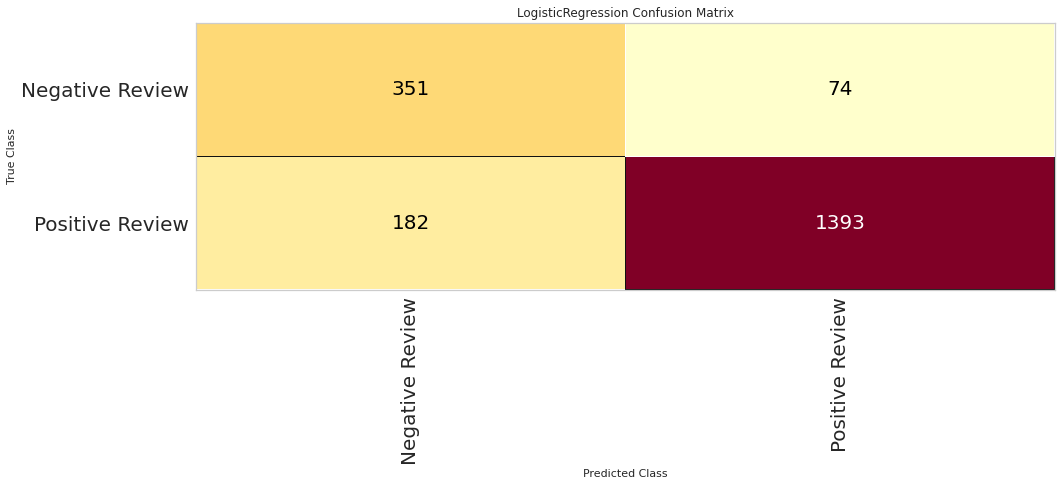

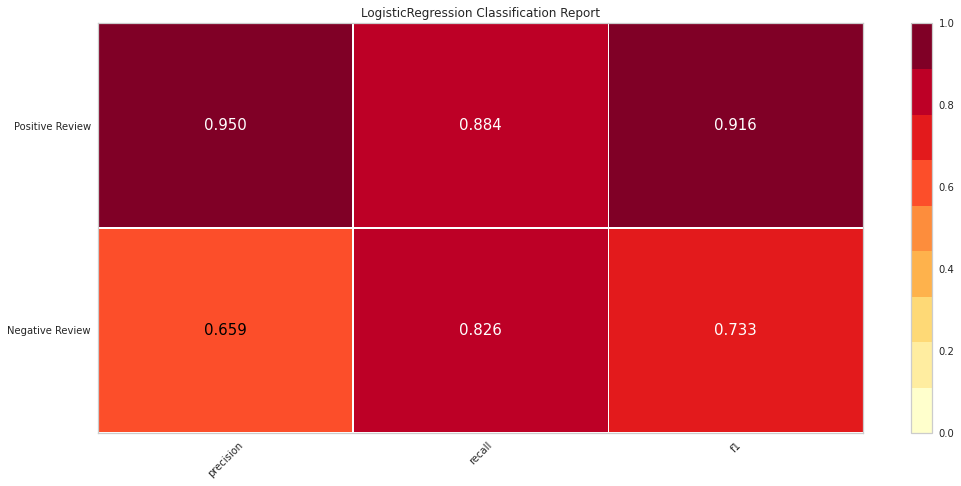

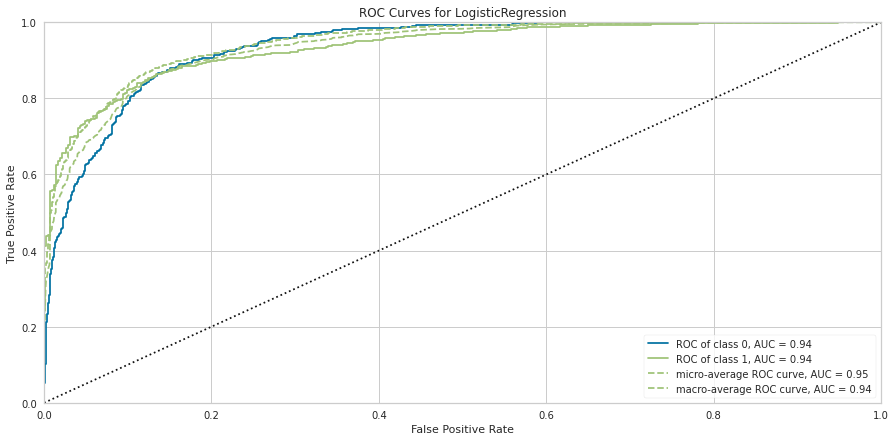

In [36]:
classes = ['Negative Review','Positive Review']
cm = ConfusionMatrix(logreg, classes=classes, percent=False)

#Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
#cm.fit(X_train, y_train)


#To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
#and then creates the confusion_matrix from scikit learn.
cm.score(X_test1,y_test)

# change fontsize of the labels in the figure
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 15
#How did we do?
cm.poof()

# Instantiate the visualizer
visualizer = ClassificationReport(logreg, classes=classes)
#visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test1,y_test)  # Evaluate the model on the test data
g = visualizer.poof()

# ROC and AUC
#Instantiate the visualizer
visualizer = ROCAUC(logreg)

#visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.fit(X_bal, y_bal)
visualizer.score(X_test1,y_test)  # Evaluate the model on the test data
plt.rcParams['font.size'] = 20
g = visualizer.poof()

### 2. Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier

my_random_forest = RandomForestClassifier(random_state=1)
my_random_forest.fit(X_bal, y_bal)
print(f"Random Forest: {my_random_forest.score(X_bal, y_bal)}")
print(f"Random Forest: {my_random_forest.score(X_test1, y_test)}")

Random Forest: 0.999919028340081
Random Forest: 0.873


In [44]:
print(f"Score on training set: Random Forest: {my_random_forest.score(X_bal, y_bal)}")
print(f"Score on test set: Random Forest: {my_random_forest.score(X_test1, y_test)}")

Score on training set: Random Forest: 0.999919028340081
Score on test set: Random Forest: 0.873


### To find the optimal n_estimators parameter, we are going to try various number of n_estimators as shown below.

In [45]:
dt_train=[]
dt_test=[]
depth=[]
for i in range(1,20):
    my_random_forest = RandomForestClassifier(n_estimators=i,random_state=1)
    my_random_forest.fit(X_bal, y_bal)
    dt_train.append(my_random_forest.score(X_bal, y_bal))
    dt_test.append(my_random_forest.score(X_test1, y_test))
    depth.append(i)

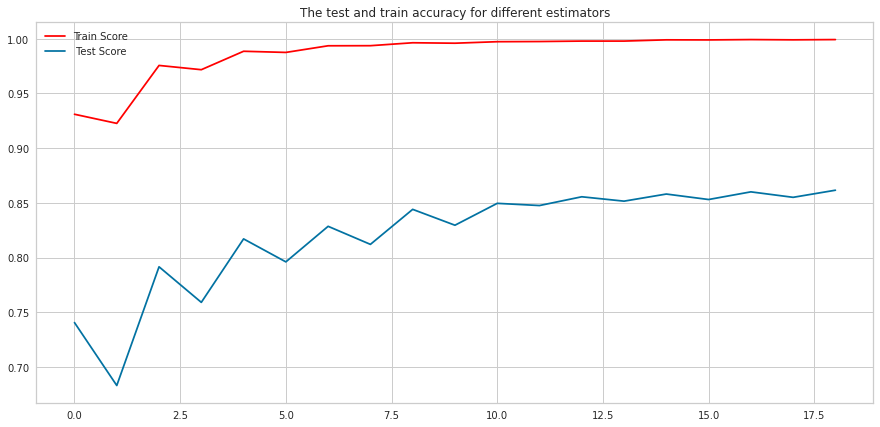

19


In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure()
plt.title('The test and train accuracy for different estimators')
plt.plot(dt_train,color='red',label='Train Score')
plt.plot(dt_test,label=' Test Score')
plt.legend()
plt.show()
print(depth[np.argmax(dt_test)])

### Now we found the optimal n_estimators as 14, the both train and test accuracy are increased.

In [51]:
my_random_forest = RandomForestClassifier(n_estimators=14,random_state=1)
my_random_forest.fit(X_bal, y_bal)
print(f"Random Forest train: {my_random_forest.score(X_bal, y_bal)}")
print(f"Random Forest test: {my_random_forest.score(X_test1, y_test)}")

Random Forest train: 0.9978137651821862
Random Forest test: 0.8515


In [52]:
# Predicting the test set results
y_pred_rand = my_random_forest.predict(X_test1)

In [53]:
# Creating confusion matrix/ dataFrame
con_mat_RF = confusion_matrix(y_test, y_pred_rand)
df_cm_RF = pd.DataFrame(con_mat_RF, columns = ['Predicted 0','Predicted 1'], index = ['True 0','True 1'])
df_cm_RF

,Predicted 0,Predicted 1
True 0,294,131
True 1,166,1409


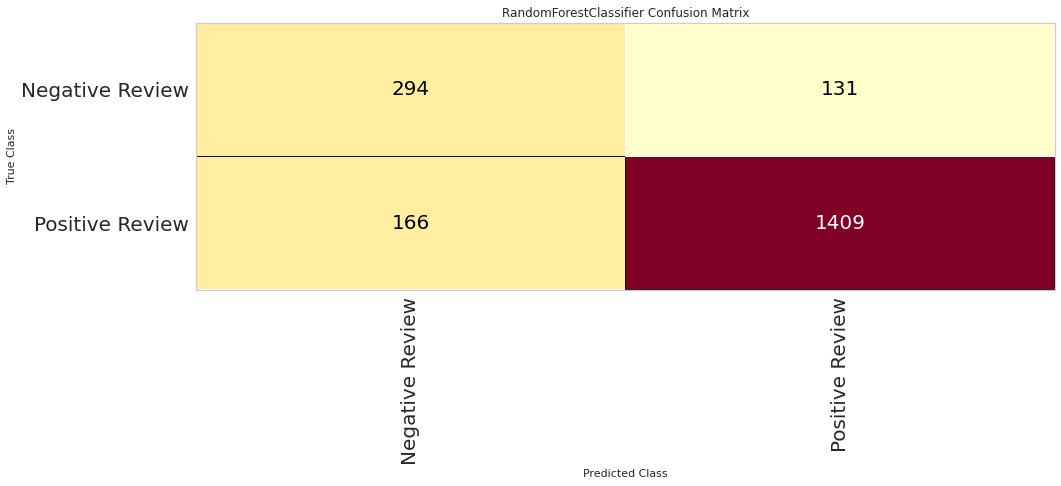

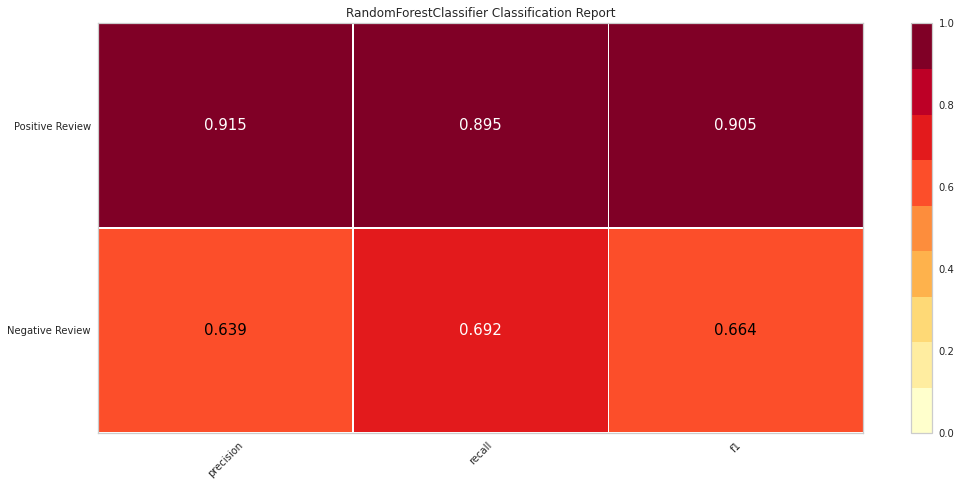

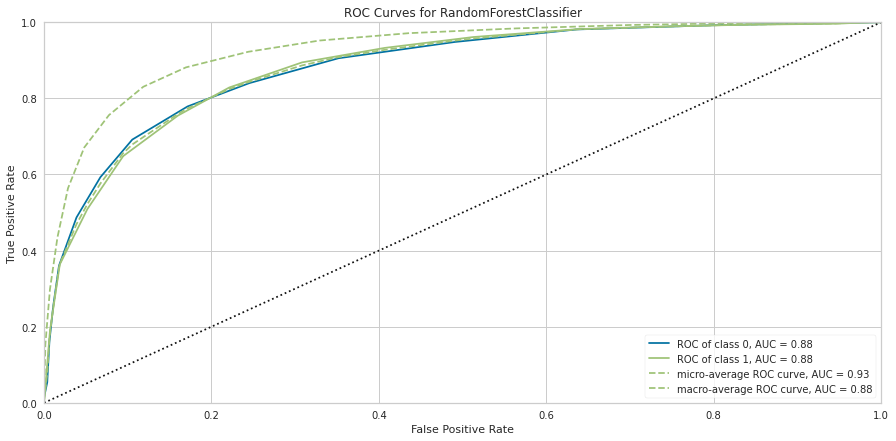

In [54]:
classes = ['Negative Review','Positive Review']
cm = ConfusionMatrix(my_random_forest, classes=classes, percent=False)

#Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
#cm.fit(X_train, y_train)


#To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
#and then creates the confusion_matrix from scikit learn.
cm.score(X_test1,y_test)

# change fontsize of the labels in the figure
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 15
#How did we do?
cm.poof()

# Instantiate the visualizer
visualizer = ClassificationReport(my_random_forest, classes=classes)
#visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test1,y_test)  # Evaluate the model on the test data
g = visualizer.poof()

# ROC and AUC
#Instantiate the visualizer
visualizer = ROCAUC(my_random_forest)

#visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.fit(X_bal, y_bal)
visualizer.score(X_test1,y_test)  # Evaluate the model on the test data
plt.rcParams['font.size'] = 20
g = visualizer.poof()

### 3. XGboost

In [55]:
from xgboost import XGBClassifier

XGB_model = XGBClassifier(random_state=1)
XGB_model.fit(X_bal, y_bal)

print(f"XG Boost train score: {XGB_model.score(X_bal, y_bal)}")
print(f"XG Boost test score: {XGB_model.score(X_test1, y_test)}")

XG Boost train score: 0.9070445344129555
XG Boost test score: 0.8625


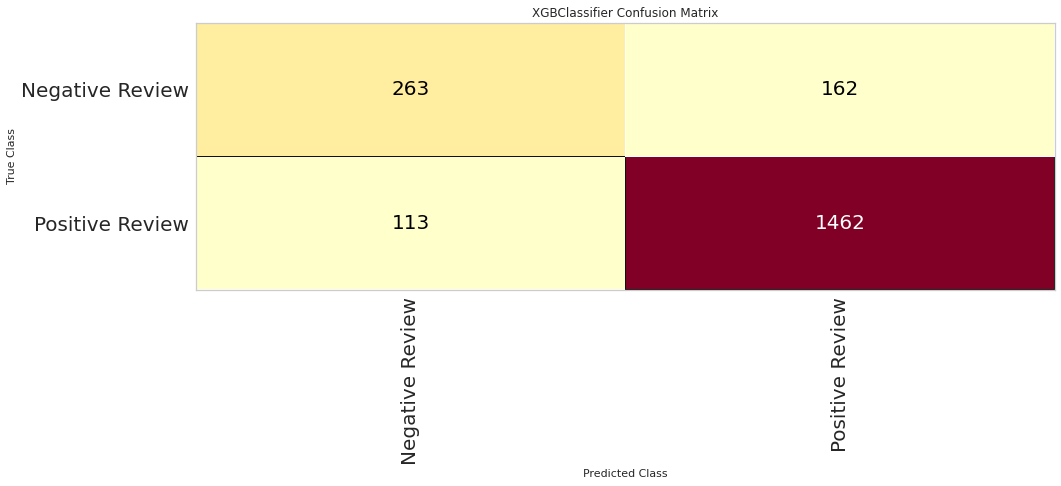

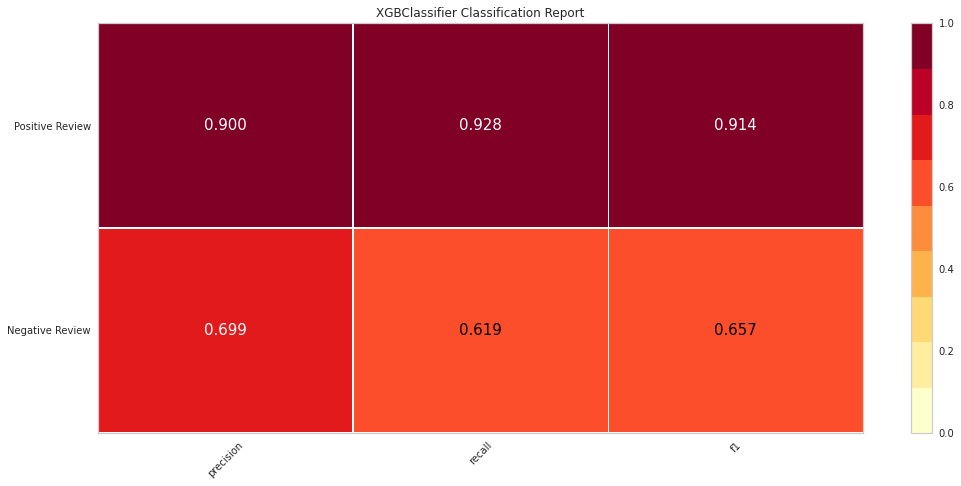

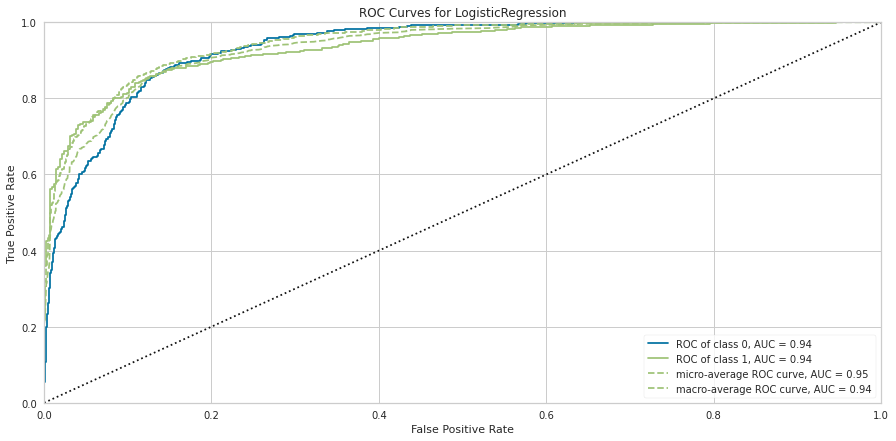

In [56]:
classes = ['Negative Review','Positive Review']
cm = ConfusionMatrix(XGB_model, classes=classes, percent=False)

#Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
#cm.fit(X_train, y_train)


#To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
#and then creates the confusion_matrix from scikit learn.
cm.score(X_test1,y_test)

# change fontsize of the labels in the figure
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 15
#How did we do?
cm.poof()

# Instantiate the visualizer
visualizer = ClassificationReport(XGB_model, classes=classes)
#visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test1,y_test)  # Evaluate the model on the test data
g = visualizer.poof()

# ROC and AUC
#Instantiate the visualizer
visualizer = ROCAUC(logreg)

#visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.fit(X_bal, y_bal)
visualizer.score(X_test1,y_test)  # Evaluate the model on the test data
plt.rcParams['font.size'] = 20
g = visualizer.poof()

### As a result, among the all three models, the Logistic Regression gave us the highest test accuracy score as 0.90 and after that the RandomForest with 0.87.

### Testing
#### In this stage, after creating the different classification models, now we can use them to predict the sentiment of the restaurant reviews.

#### (Negative review):
#### "The waiting time was really long."

In [57]:
input_string = "The waiting time was really long."
print("\nPrediction on an input string: " + input_string)
print("Logistic Regression model:",logreg.predict(vect_1.transform([function_clean(input_string)])))
print("Random Forest model      :",my_random_forest.predict(vect_1.transform([function_clean(input_string)])))
print("XGboost model            :",XGB_model.predict(vect_1.transform([function_clean(input_string)])))


Prediction on an input string: The waiting time was really long.
Logistic Regression model: [0]
Random Forest model      : [0]
XGboost model            : [1]


#### (Negative review):
#### "I haven't had a lunch this bad for a really long time.  It was disgusting!"

In [58]:
input_string = "I haven't had a lunch this bad for a really long time.  It was disgusting!."
print("\nPrediction on an input string: " + input_string)
print("Logistic Regression model:",logreg.predict(vect_1.transform([function_clean(input_string)])))
print("Random Forest model      :",my_random_forest.predict(vect_1.transform([function_clean(input_string)])))
print("XGboost model            :",XGB_model.predict(vect_1.transform([function_clean(input_string)])))


Prediction on an input string: I haven't had a lunch this bad for a really long time.  It was disgusting!.
Logistic Regression model: [0]
Random Forest model      : [0]
XGboost model            : [0]


#### (Positive review)
#### "people that works here for sure is friendly! :) I do love that big menu."

In [59]:
input_string = " people that works here for sure is friendly! :)I do love that big menu book and seems like there are a lot of items to choose from. This is always nice as Vietnamese food is definitely more than pho and more spring rolls."
print("\nPrediction on an input string: " + input_string)
print("Logistic Regression model:",logreg.predict(vect_1.transform([function_clean(input_string)])))
print("Random Forest model      :",my_random_forest.predict(vect_1.transform([function_clean(input_string)])))
print("XGboost model            :",XGB_model.predict(vect_1.transform([function_clean(input_string)])))


Prediction on an input string:  people that works here for sure is friendly! :)I do love that big menu book and seems like there are a lot of items to choose from. This is always nice as Vietnamese food is definitely more than pho and more spring rolls.
Logistic Regression model: [1]
Random Forest model      : [1]
XGboost model            : [1]


#### (Positive review)
#### "The staff is friendly, and the food is good. They have a good selection of drinks"

In [60]:
input_string = "The staff is friendly, and the food is good. They have a good selection of drinks"
print("\nPrediction on an input string: " + input_string)
print("Logistic Regression model:",logreg.predict(vect_1.transform([function_clean(input_string)])))
print("Random Forest model      :",my_random_forest.predict(vect_1.transform([function_clean(input_string)])))
print("XGboost model            :",XGB_model.predict(vect_1.transform([function_clean(input_string)])))


Prediction on an input string: The staff is friendly, and the food is good. They have a good selection of drinks
Logistic Regression model: [1]
Random Forest model      : [1]
XGboost model            : [1]


In [61]:
input_string = "The staff is friendly, and the food is good. They have a good selection of drinks"
print("\nPrediction on an input string: " + input_string)
print("Logistic Regression model:",logreg.predict(vect_1.transform([function_clean(input_string)])))
print("Random Forest model      :",my_random_forest.predict(vect_1.transform([function_clean(input_string)])))
print("XGboost model            :",XGB_model.predict(vect_1.transform([function_clean(input_string)])))


Prediction on an input string: The staff is friendly, and the food is good. They have a good selection of drinks
Logistic Regression model: [1]
Random Forest model      : [1]
XGboost model            : [1]


In [37]:
input_string = "The staff is friendly, and the food is good. They have a good selection of drinks"
print("\nPrediction on an input string: " + input_string)
print("Logistic Regression model:",logreg.predict(vect_2.transform([function_clean_stop(input_string)])))


Prediction on an input string: The staff is friendly, and the food is good. They have a good selection of drinks
Logistic Regression model: [1]


Path to store the pickled model files

In [38]:
import os
#dirname = os.path.dirname(__file__)
#filename = os.path.join(dirname, '../models')
print(os.path.realpath('..'))
model_path = os.path.realpath('..') + "/models"
print(model_path)
#os.mkdir(model_path)

/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-cpu-ds12-v2/code/Users/rabiswas/Yelp
/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-cpu-ds12-v2/code/Users/rabiswas/Yelp/models


In [39]:
import joblib
joblib.dump(logreg, Path(model_path, 'logreg.pkl'))

['/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-cpu-ds12-v2/code/Users/rabiswas/Yelp/models/logreg.pkl']

In [81]:
import joblib
from pathlib import Path
import sklearn
joblib.dump(logreg, Path(model_path, 'logreg.pkl'))
joblib.dump(my_random_forest, Path(model_path, 'random_forest.pkl'))
joblib.dump(XGB_model, Path(model_path, 'XGB.pkl'))
print("Trained models using scikit-learn {}.".format(sklearn.__version__))

Trained models using scikit-learn 0.23.2.


In [40]:
logreg_classifier = joblib.load(Path(model_path, 'logreg.pkl'))

In [42]:
input_string = "I haven't had a lunch this bad for a really long time.  It was disgusting!."
print("\nPrediction on an input string: " + input_string)
print("Logistic Regression model:",logreg_classifier.predict(vect_2.transform([function_clean_stop(input_string)])))


Prediction on an input string: I haven't had a lunch this bad for a really long time.  It was disgusting!.
Logistic Regression model: [0]


In [43]:
# Determine sentiment from score
def decode_sentiment(score):
    if score == 0:
        return "NEGATIVE"
    else:
        return "POSITIVE"

In [45]:
input_string = "I haven't had a lunch this bad for a really long time.  It was disgusting!."
print("\nPrediction on an input string: " + input_string)
print("Logistic Regression model Prediction:",decode_sentiment(logreg_classifier.predict(vect_2.transform([function_clean_stop(input_string)]))))


Prediction on an input string: I haven't had a lunch this bad for a really long time.  It was disgusting!.
Logistic Regression model Prediction: NEGATIVE


In [125]:
####****
#joblib.dump(vect_1, Path(model_path, 'tf_idf.pkl'))

['/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-cpu-ds12-v2/code/Users/rabiswas/Yelp/models/tf_idf.pkl']

In [46]:
joblib.dump(vect_2, Path(model_path, 'tf_idf.pkl'))

['/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-cpu-ds12-v2/code/Users/rabiswas/Yelp/models/tf_idf.pkl']

In [47]:
vect_transformer = joblib.load(Path(model_path, 'tf_idf.pkl'))

In [102]:
type(vect_transformer)

sklearn.feature_extraction.text.TfidfVectorizer

In [48]:
input_string = "I haven't had a lunch this bad for a really long time.  It was disgusting!."
print("\nPrediction on an input string: " + input_string)
print("Logistic Regression model Prediction:",decode_sentiment(logreg_classifier.predict(vect_transformer.transform([function_clean_stop(input_string)]))))


Prediction on an input string: I haven't had a lunch this bad for a really long time.  It was disgusting!.
Logistic Regression model Prediction: NEGATIVE


In [49]:
from azureml.core.model import Model
# Tip: When model_path is set to a directory, you can use the child_paths parameter to include
#      only some of the files from the directory
model = Model.register(model_path = "../models/logreg.pkl",
                       model_name = "yelp_logreg_classifier",
                       description = "Sentiment analysis model",
                       workspace = workspace)

Registering model yelp_logreg_classifier


In [50]:
from azureml.core.model import Model
# Tip: When model_path is set to a directory, you can use the child_paths parameter to include
#      only some of the files from the directory
model_vect_transformer = Model.register(model_path = "../models/tf_idf.pkl",
                       model_name = "vect_transformer",
                       description = "tf_idf vectorizer fit and transform",
                       workspace = workspace)

Registering model vect_transformer


Define inference configuration
The inference configuration defines the environment used to run the deployed model. The inference configuration references the following entities, which are used to run the model when it's deployed:

An entry script, named score.py, loads the model when the deployed service starts. This script is also responsible for receiving data, passing it to the model, and then returning a response.
An Azure Machine Learning environment. An environment defines the software dependencies needed to run the model and entry script.


Use a custom environment
If you want more control over how your model is run, if it uses another framework, or if it has special runtime requirements, you can instead specify your own environment and scoring method. Custom environments can be used for any model you want to deploy.

Specify the model's runtime environment by creating an Environment object and providing the CondaDependencies needed by your model.

In [51]:
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies


environment = Environment('yelp-environment')
environment.python.conda_dependencies = CondaDependencies.create(pip_packages=[
    'azureml-defaults',
    'inference-schema[numpy-support]',
    'joblib',
    'numpy',
    'scikit-learn=={}'.format(sklearn.__version__),
    'nltk'
])

In [204]:
print('scikit-learn=={}'.format(sklearn.__version__))

scikit-learn==0.23.2


In [45]:
!python ../score/working_score-copy.py

run
init
function_clean
decode_sentiment
{'label': 'NEGATIVE', 'score': 0.0, 'elapsed_time': 1.8782167434692383}


In [52]:
!python ../score/test.py

In [53]:
from azureml.core.model import InferenceConfig
inference_config = InferenceConfig(entry_script="../score/score.py",
                                   environment=environment)

In [148]:
#envs = Environment.list(workspace=workspace)

#for env in envs:
#    if env.startswith("AzureML"):
#        print("Name",env)
#        print("packages", envs[env].python.conda_dependencies.serialize_to_string())

In [147]:
#from azureml.core.environment import Environment
#from azureml.core.model import InferenceConfig


#env = Environment.get(workspace, "AzureML-Tutorial").clone(env_name)

#for pip_package in ["scikit-learn"]:
#    env.python.conda_dependencies.add_pip_package(pip_package)

In [57]:
Model.get_model_path(model_name='yelp_logreg_classifier',_workspace=workspace)

'azureml-models/yelp_logreg_classifier/5/logreg.pkl'

In [55]:
Model.get_model_path(model_name='vect_transformer',_workspace=workspace)

'azureml-models/vect_transformer/4/tf_idf.pkl'

In [58]:
from azureml.core.model import Model
#model1 = Model(workspace, 'yelp_logreg_classifier')
model_path = Model.get_model_path(model_name='yelp_logreg_classifier')
# Construct the model path using the registered model name, version, and model file name
#model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'yelp_logreg_classifier', '1', 'logreg.pkl')
model11 = joblib.load(model_path)
vect_transformer_path = Model.get_model_path(model_name='vect_transformer')
vect_transformer11 = joblib.load(vect_transformer_path)
input_string = "I haven't had a lunch this bad for a really long time.  It was disgusting!."
print("\nPrediction on an input string: " + input_string)
print("Logistic Regression model Prediction:",decode_sentiment(model11.predict(vect_transformer11.transform([function_clean_stop(input_string)]))))


Prediction on an input string: I haven't had a lunch this bad for a really long time.  It was disgusting!.
Logistic Regression model Prediction: NEGATIVE


In [3]:
######*****

#from azureml.core.webservice import AciWebservice, Webservice
#from azureml.core.model import Model
#logging.basicConfig(level=logging.DEBUG)
#deployment_config = AciWebservice.deploy_configuration(cpu_cores = 2, memory_gb = 4)
#service = Model.deploy(workspace, "sentimentscore", [model,model_vect_transformer], inference_config, deployment_config)
#service = Model.deploy(workspace, "sentiment", [Model(workspace, name='yelp_logreg_classifier'],Model(workspace, name='yelp_logreg_classifier']], inference_config, deployment_config)

#service.wait_for_deployment(show_output = True)
#print(service.get_logs())
#print(service.state)

In [59]:
from azureml.core.webservice import AciWebservice, Webservice
from azureml.core.model import Model
#logging.basicConfig(level=logging.DEBUG)
deployment_config = AciWebservice.deploy_configuration(cpu_cores = 1, memory_gb = 1)
service = Model.deploy(workspace, "sentimentscore", [model,model_vect_transformer], inference_config, deployment_config)

service.wait_for_deployment(show_output = True)
print(service.get_logs())
print(service.state)

DEBUG:azureml.ArtifactsClient.batch_create_empty_artifacts-async:False:[START]
DEBUG:azureml.ArtifactsClient:ClientBase: Calling batch_create_empty_artifacts with url /artifact/v2.0/subscriptions/{subscriptionId}/resourceGroups/{resourceGroupName}/providers/Microsoft.MachineLearningServices/workspaces/{workspaceName}/artifacts/batch/metadata/{origin}/{container}
DEBUG:msrest.service_client:Accept header absent and forced to application/json
DEBUG:adal-python:806e97ee-0dae-40d3-8e54-e261c7fd8ac3 - Authority:Performing instance discovery: ...
DEBUG:adal-python:806e97ee-0dae-40d3-8e54-e261c7fd8ac3 - Authority:Performing static instance discovery
DEBUG:adal-python:806e97ee-0dae-40d3-8e54-e261c7fd8ac3 - Authority:Authority validated via static instance discovery
DEBUG:adal-python:806e97ee-0dae-40d3-8e54-e261c7fd8ac3 - TokenRequest:Getting token from cache with refresh if necessary.
DEBUG:adal-python:806e97ee-0dae-40d3-8e54-e261c7fd8ac3 - CacheDriver:finding with query keys: {'_clientId': '.

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running......................
Succeeded
ACI service creation operation finished, operation "Succeeded"
2021-02-22T06:11:13,580414800+00:00 - rsyslog/run 
2021-02-22T06:11:13,581314300+00:00 - gunicorn/run 
2021-02-22T06:11:13,592538100+00:00 - iot-server/run 
2021-02-22T06:11:13,630692800+00:00 - nginx/run 
/usr/sbin/nginx: /azureml-envs/azureml_028d1390f0483cfd64b33757458ea0e3/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_028d1390f0483cfd64b33757458ea0e3/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_028d1390f0483cfd64b33757458ea0e3/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azurem

In [62]:
import requests
import json

#scoring uri for the service
scoring_uri = 'http://185144fa-e9a4-496e-ad64-46aef167e911.eastus2.azurecontainer.io/score'
headers = {'Content-Type':'application/json'}
#headers = {'Content-Type':'application/text'}

test_data = json.dumps({'text': 'The cumin lamb was amazing'})

response = requests.post(scoring_uri, data=test_data, headers=headers)
print(response.status_code)
print(response.elapsed)
print(response.json())

DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): 185144fa-e9a4-496e-ad64-46aef167e911.eastus2.azurecontainer.io:80
DEBUG:urllib3.connectionpool:http://185144fa-e9a4-496e-ad64-46aef167e911.eastus2.azurecontainer.io:80 "POST /score HTTP/1.1" 200 73


200
0:00:00.019383
{'label': 'POSITIVE', 'score': 1.0, 'elapsed_time': 0.006325721740722656}


In [196]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))
mlp.fit(X_bal, y_bal)

MLPClassifier(hidden_layer_sizes=(30, 30, 30))

In [197]:
# Predicting the test set results
y_pred_mlp = mlp.predict(X_test1)

# Training score
print(f"Score on training set: {mlp.score(X_train1,y_train)}")
print(f"Score on test set: {mlp.score(X_test1,y_test)}")

# Creating confusion matrix/ dataFrame
con_mat_mlp = confusion_matrix(y_test, y_pred_mlp)
df_cm_mlp = pd.DataFrame(con_mat_mlp, columns = ['Predicted 0','Predicted 1'], index = ['True 0','True 1'])
df_cm_mlp

Score on training set: 0.999875
Score on test set: 0.8675


,Predicted 0,Predicted 1
True 0,302,123
True 1,142,1433


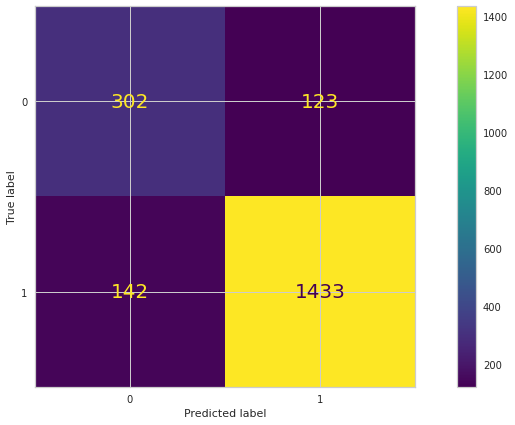

In [199]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(mlp,X_test1,y_test)